**<div style="text-align: center;">ETHNICS INEQUALITIES WITHIN WIKISPEEDIA</div>**

**IMPORT THE LIBRARY**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
from tqdm import tqdm 
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
from unidecode import unidecode
from matplotlib.colors import Normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot


**OPEN THE DATA**

In [2]:
#Open and import the dataset 
dataFolder = 'Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()

#We change how some names are wrote so that there are similar to the names in in paths_finishedDf and paths_unfininishedDf 
people_skin_color['People'] = people_skin_color['People'].replace('Adolf Hitler', 'Adolf_Hitler')
#people_skin_color

categories_details = categoriesDf["categories"].str.split(".", expand=True)
#keep only the main category
threshold = 100
categories = pd.concat([categories_details[1], categories_details[2], categories_details[3]],axis = 0)
categories = pd.DataFrame(categories)
categories = categories.rename(columns = {0 : 'Main_Categories'})

categories_distribution=categories['Main_Categories'].value_counts()
 
categories_distribution['People'] = categories_distribution['People'] + categories_distribution['Peoples']
categories_distribution = categories_distribution.drop('Peoples')
categories_distribution = categories_distribution[categories_distribution > threshold]
categories_distribution = categories_distribution.sort_values()

**1. Distribution of articles in each categories**


The dataset 'categories' contains main categories and then sub-categories. We will focus on main categories.

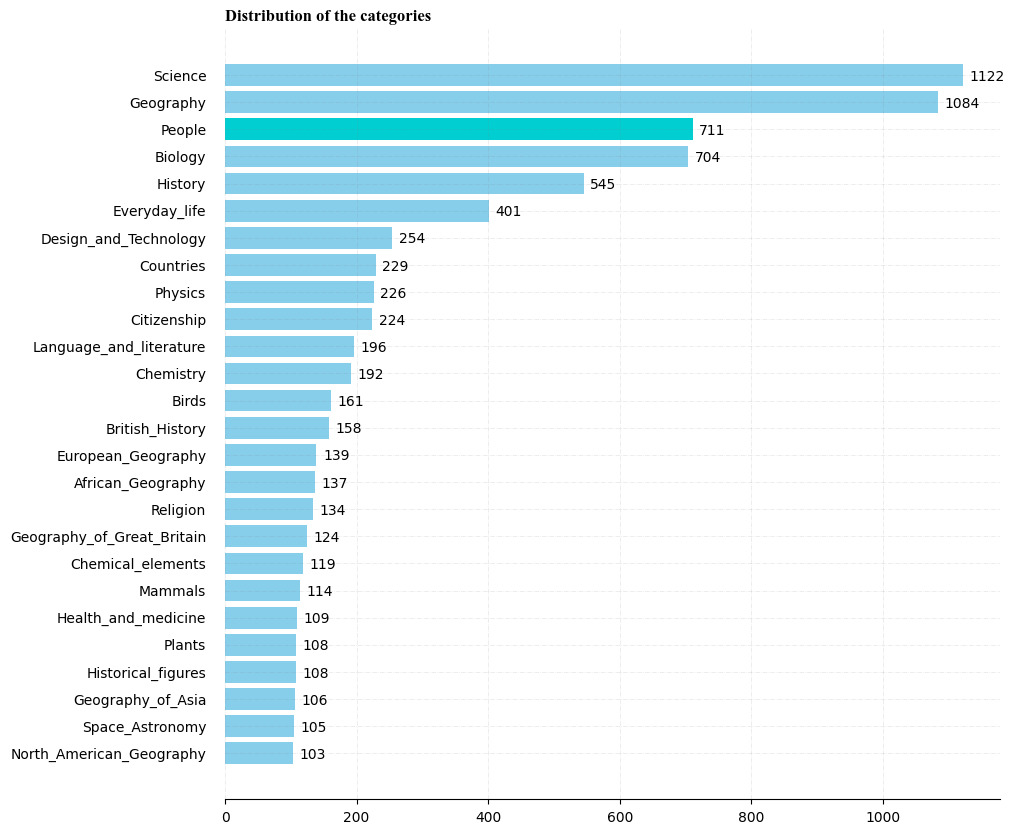

In [3]:
fig, ax = plt.subplots(figsize =(10, 10))
colors = ['skyblue' if cat != 'People' else 'darkturquoise' for cat in categories_distribution.index]
ax.barh(categories_distribution.index, categories_distribution, color=colors)
 
# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove y Tick
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
 

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() +10, i.get_y()+0.20, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

ax.set_title('Distribution of the categories', loc='left', fontweight= 'bold', fontname='Times New Roman')

plt.show()


People is the third category containing the bigger amount of articles (around 700 articles). We will know focus on this category and used our new dataset 'people_with_skin_color.tsv'

**2. The ethnics distribution whitin people articles**

To continue, we will focus on the ethnics distribution whithin the people articles. Ethnicity is a quality or a fact of belonging to a population group or subgroup made up of people who share a common cultural background or descent. Here we class the people on physical ethnicity which means we class them to have large groups of people with common racial, national, tribal, religious, linguistic, or cultural origin or background.  
We assign the ethnics groups of each person contained in the People category based on their physical ethnicity appartenance. To make it easier for us, we decide to focus on the following main ethnic groups : 
- White 
- Asian
- Black  
- Arab-Persian-Byzantin
- Hispanic 
- American Indian
- Australian aboriginal

In [4]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color']

people_color_dist=people_color['Skin Color'].value_counts()
people_color_dist


Skin Color
White                    608
Asian                     37
Black                     32
Arab-Persian-Bizantin     23
Hispanic                   7
American Indian            1
Australian Aboriginal      1
Name: count, dtype: int64

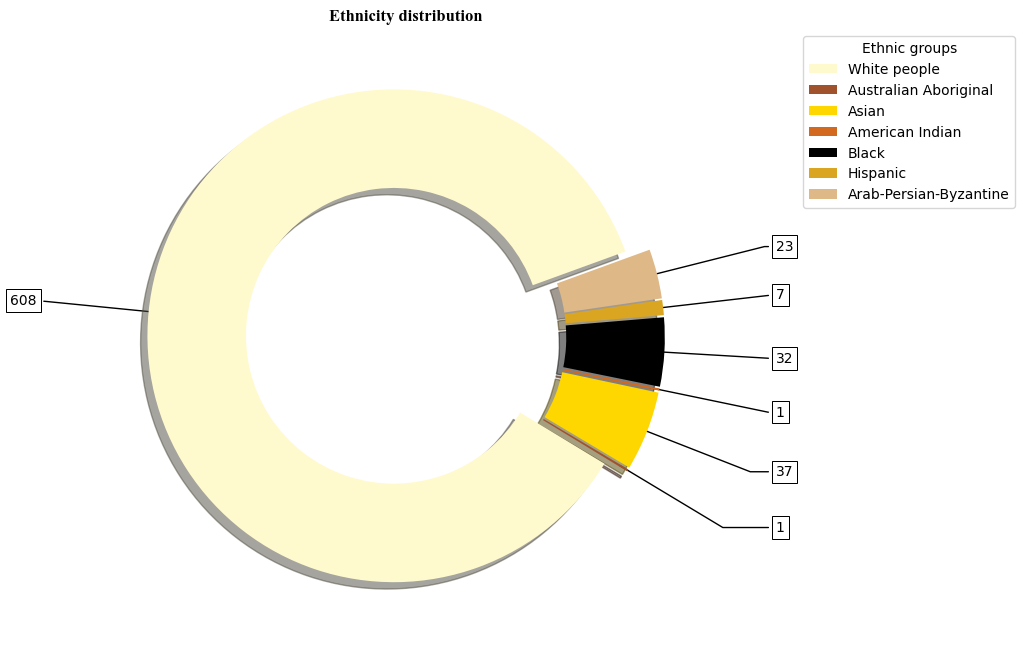

In [5]:
#Vizualise the data
labels2 = 'White people', 'Australian Aboriginal', 'Asian', 'American Indian', 'Black', 'Hispanic', 'Arab-Persian-Byzantine'
people_dist_order = [people_color_dist.iloc[0], people_color_dist.iloc[6],people_color_dist.iloc[1],
                     people_color_dist.iloc[5],people_color_dist.iloc[2],people_color_dist.iloc[4],
                     people_color_dist.iloc[3]]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect='equal'))

wedges, texts = ax.pie(people_dist_order , wedgeprops=dict(width=0.4), startangle=20, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], 
                       colors=sns.color_palette(['lemonchiffon','sienna','gold','chocolate','black','goldenrod','burlywood']),shadow=True)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(people_dist_order[i], xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw)
ax.legend(wedges,labels2, title="Ethnic groups",bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Ethnicity distribution', fontweight= 'bold', fontname='Times New Roman')

plt.show()


The white person's pages appears to be an overwhelming majority. While the other ethnic groups share a sixth of the pages, white people cover 5/6 of the people articles. So Wikispeedia contains more article about white personalities. This already show the inequal representation of the different ethnics groups within the game. With this knowledge, it is now interesting to analyse how this influences the game. Does a person's ethnic group influence the difficulty of the game ? Are certain ethnic groups more widely used or more advantageous ?

As white people are dominant, in a huge part of our analysis, we will group all ethnic groups except whites under other ethnic groups. 

**3. Target People**

An interesting question that will be our guiding principle is: 

_Does the ethnicity of the person targeted have an influence on the outcome of the game (win or lose)?_

In the first place, it is interesting to look at the proportion of target in each ethnics groups in both paths_finished.tsv and paths_unfinished.tsv. The breakdown is expected to be similar to the previous one.

In [6]:
#Create a dataframe with the path decompose (each cells represents one article of the paths)
path =  paths_finishedDf['path'].str.split(";", expand=True)

#Only keep People's name
people_name= people_color['People']
people_set = set(people_name.tolist())

#Find the path containing article from People's category
people = path.isin(people_set)
rows_with_people = people.any(axis=1)

#Only keep the rows of path which contains at least one people in the path
people_path = path[rows_with_people]

In [7]:
# Find all the path containing a people as FINAL target and extract the starting article corresponding to it 
people_target_finish = []
index_target = []

start_finish= []

for index, row in tqdm(people_path.iterrows()):
    no_none_value = [value for value in row if value != None]
    if no_none_value[-1] in people_name.tolist() :
        people_target_finish.append(no_none_value[-1])
        index_target.append(index)
        start_finish.append(no_none_value[0])


3161it [00:00, 23032.61it/s]


In [8]:
#Count how many times each people are target
people_target_count = pd.Series(people_target_finish).value_counts().reset_index()
people_target_count.columns =['People', 'Count']

#Merge with the original color_people dataframe to have the informations on the ethnicity and category
people_target_df = people_target_count.merge(people_color)

In [9]:
unfinished_target_people = paths_unfinishedDf[paths_unfinishedDf['target'].isin(people_name)]

index_target_unfinish = unfinished_target_people.index
target_unfinish = unfinished_target_people['target']

unfinish = unfinished_target_people['target'].value_counts().reset_index()
unfinish.columns = ['People', 'Count']

#Merge with the original color_people dataframe to have the informations on the ethnicity and category
people_target_unfinish = unfinish.merge(people_color)
people_target_df


,People,Count,Skin Color,2
0,Adolf_Hitler,603,White,Political_People
1,Jesus,197,Arab-Persian-Bizantin,Religious_figures_and_leaders
2,Socrates,46,White,Philosophers
3,Muhammad,43,Arab-Persian-Bizantin,Religious_figures_and_leaders
4,Buddha,33,Asian,Religious_figures_and_leaders
5,Aristotle,31,White,Philosophers
6,Confucius,28,Asian,Philosophers
7,Hippocrates,25,White,Human_Scientists
8,Plato,22,White,Philosophers
9,Pythagoras,20,White,Mathematicians


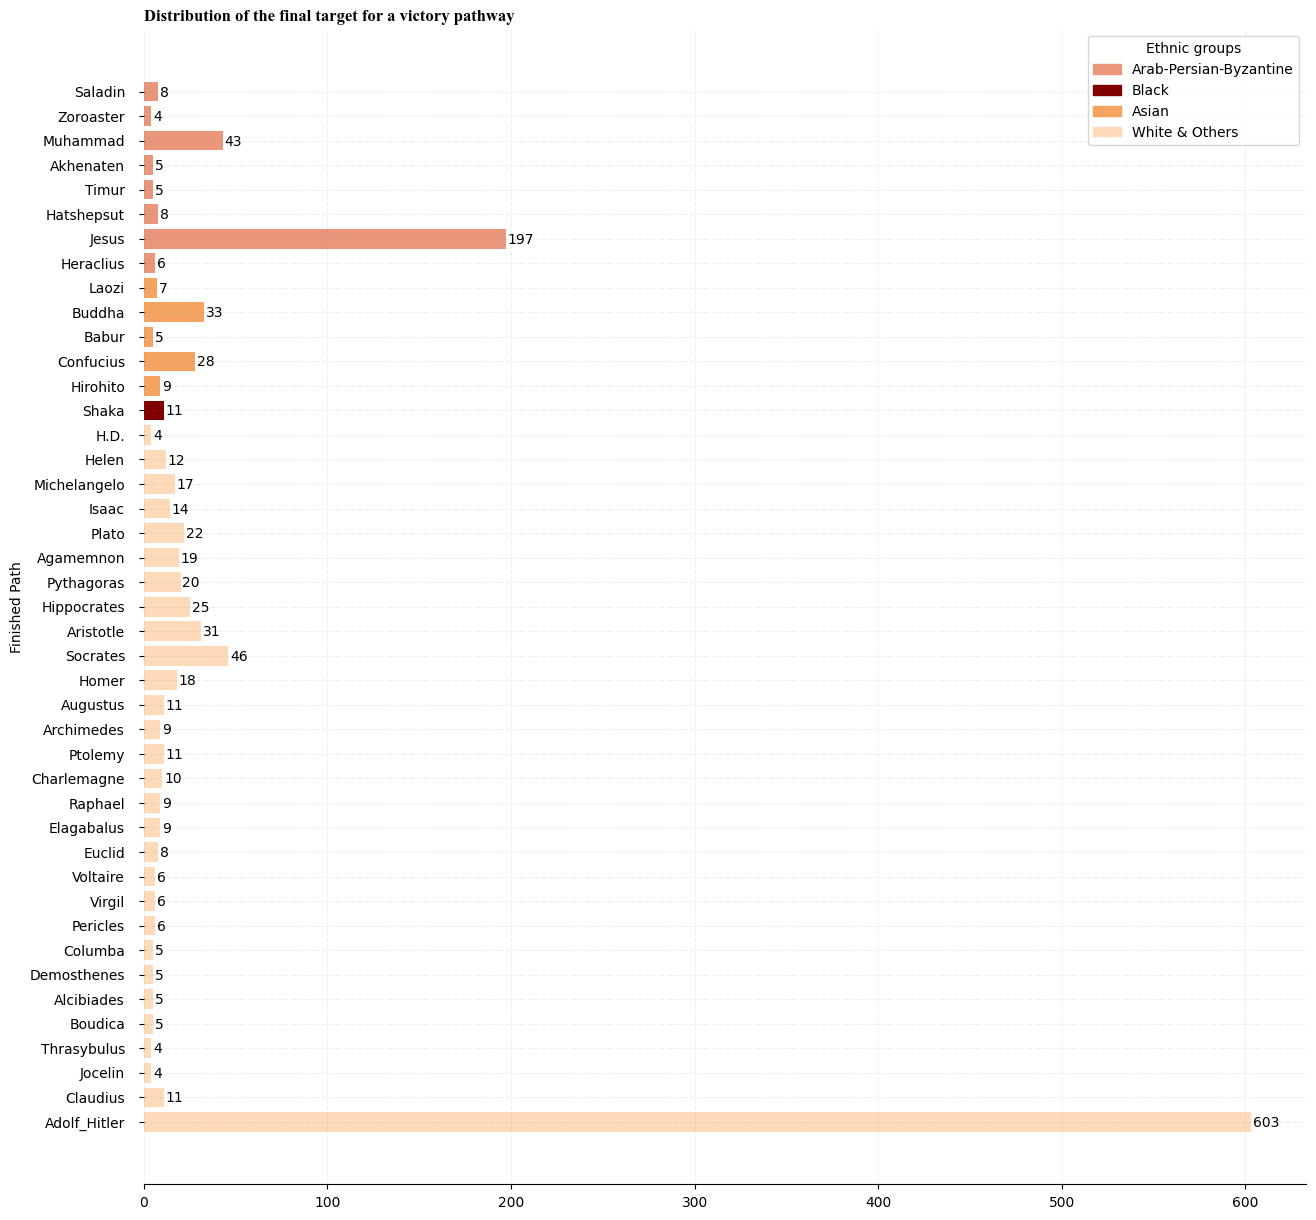

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))

# Sorting the DataFrames
people_target_df = people_target_df.sort_values('Skin Color',ascending=False)
people_target_unfinish = people_target_unfinish.sort_values(by='Skin Color',ascending=False)

# Define colors based on ethnicities
couleur1 = ['darksalmon' if ethnic == 'Arab-Persian-Bizantin' else 'maroon' if ethnic == 'Black' else 'sandybrown' if ethnic == 'Asian' 
            else 'peachpuff' for ethnic in people_target_df['Skin Color']]
couleur2 = ['darksalmon' if ethnic == 'Arab-Persian-Bizantin' else 'maroon' if ethnic == 'Black' else 'sandybrown' if ethnic == 'Asian' 
            else 'peachpuff' for ethnic in people_target_unfinish['Skin Color']]

# Plotting the finished path
ax.barh(people_target_df['People'], people_target_df['Count'], color=couleur1)

# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

ax.set_ylabel('Finished Path')
for i in ax.patches:
    plt.text(i.get_width()+1, i.get_y()+0.20, 
             str(round((i.get_width()), 2)),
             fontsize = 10)
    
ax.set_title('Distribution of the final target for a victory pathway', fontname='Times New Roman', fontweight='bold', loc ='left')

colors = {'Arab-Persian-Byzantine':'darksalmon', 'Black':'maroon', 'Asian':'sandybrown', 'White & Others': 'peachpuff'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles,labels, title= 'Ethnic groups')
plt.show()


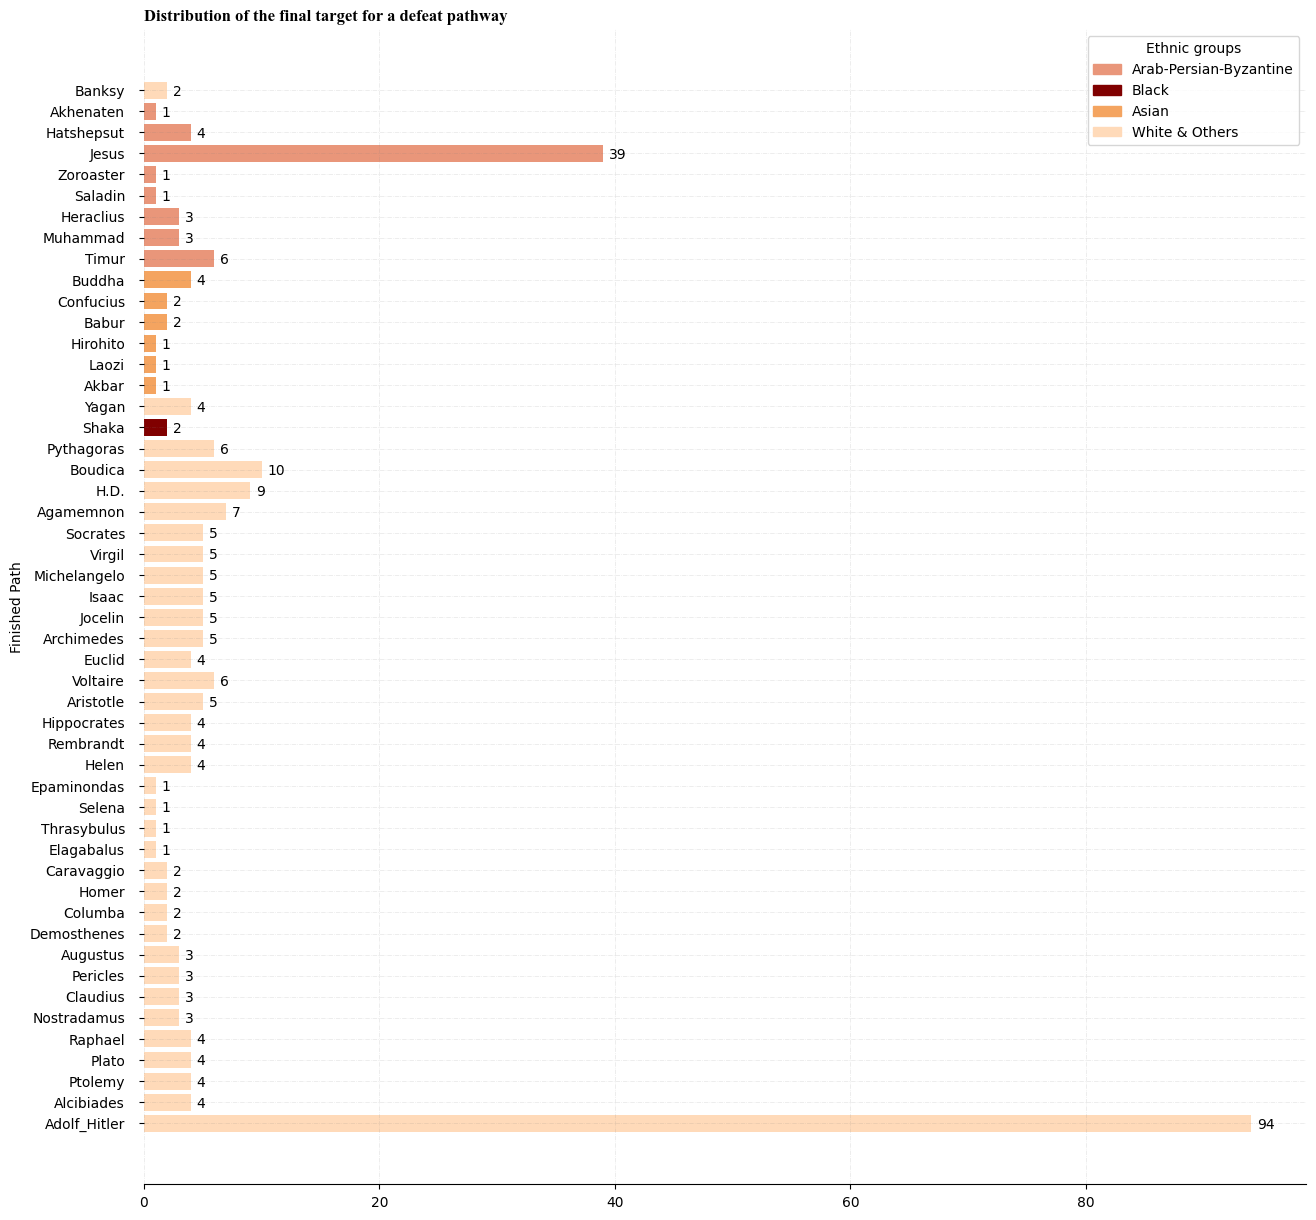

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.barh(people_target_unfinish['People'], people_target_unfinish['Count'], color=couleur2)

# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
 
ax.set_ylabel('Finished Path')
for i in ax.patches:
    plt.text(i.get_width()+0.5, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

colors = {'Arab-Persian-Byzantine':'darksalmon', 'Black':'maroon', 'Asian':'sandybrown', 'White & Others': 'peachpuff'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles,labels,title='Ethnic groups')
    
ax.set_title('Distribution of the final target for a defeat pathway', fontname='Times New Roman', fontweight='bold', loc ='left')

plt.show()

So we clearly see, that white people dominate the target of the game with in second positions black people and then east asian an arab people. Some ethnics groups are not even represented in the target such as south east people. 
Two persons are highly target : Jesus and Adolf Hitler. Those extrem values are good to know because they can strongly affect our analysis. 


**4. Study of the difficulty to win depending on the ethnics groups of the target**

So now, the focus analysis will be the finalality of the games : Victory or Defeat depending on the target person. Victory correspond to paths in the paths_finished.tsv dataset and Defeat correspoond to the paths in paths_unfinished.tsv. 

We define the difficulty of the game principally on its finality : Victory or Defeat. But it might be interesting to also consider the rated difficulty by the players, the duration time of the game and the shortest path length of the game (longer shortest path might be more difficult)

**a) NAIVE ANALYSIS**

A naïve analysis is a simplist method to analyze data without considering complex factors that might have influence. In naïve analysis, means, standard deviation and other statiscal variables are computed without modifying the data and considering all the data.

In the naïve analysis, a comparaison of the previous variables of difficulty is done depending on the target ethnic groups.


In [12]:
#Create dataframe containing the games informations for each ethnics groups target
white_people = people_color[people_color['Skin Color'] == 'White']['People'].tolist()
arab_people = people_color[people_color['Skin Color'] == 'Arab-Persian-Bizantin']['People'].tolist()
black_people = people_color[people_color['Skin Color'] == 'Black']['People'].tolist()
asian_people = people_color[people_color['Skin Color'] == 'Asian']['People'].tolist()

white_index =[]
arab_index =[]
black_index =[]
asian_index =[]

for i in range(0, len(index_target)):
    if people_target_finish[i] in white_people :
        white_index.append(index_target[i])

    if people_target_finish[i] in asian_people :
        asian_index.append(index_target[i])

    if people_target_finish[i] in arab_people:
        arab_index.append(index_target[i])

    if people_target_finish[i] in black_people :
        black_index.append(index_target[i])

target_white_path = paths_finishedDf.loc[white_index]
target_arab_path = paths_finishedDf.loc[arab_index]
target_black_path = paths_finishedDf.loc[black_index]
target_asian_path = paths_finishedDf.loc[asian_index]


First, the mean rated difficulty is computed for each ethnic groups

In [13]:
target_white_path.rating.describe()

count    487.000000
mean       2.006160
std        1.076289
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: rating, dtype: float64

In [14]:
target_black_path.rating.describe()

count    7.000000
mean     2.857143
std      0.899735
min      2.000000
25%      2.000000
50%      3.000000
75%      3.500000
max      4.000000
Name: rating, dtype: float64

In [15]:
target_arab_path.rating.describe()

count    143.000000
mean       1.881119
std        1.058098
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: rating, dtype: float64

In [16]:
target_asian_path.rating.describe()

count    49.000000
mean      2.102041
std       0.984143
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: rating, dtype: float64

Looking at this first estimation, it is difficult to say if white people target's path are less difficult than the others. Indeed, path with for target black people seems the more difficult whereas the one targeting arab people are the easier. So those results can't lead to a conclusion.

Then, the mean duration time of the games are calculated

In [17]:
#Mean duration time for the different ethnics groups target
white_mean_duration= target_white_path['durationInSec'].mean(skipna = True)
arab_mean_duration = target_arab_path['durationInSec'].mean(skipna = True)
black_mean_duration = target_black_path['durationInSec'].mean(skipna = True)
asian_mean_duration = target_asian_path['durationInSec'].mean(skipna = True)

print(f'Mean duration for white people target: { white_mean_duration:.2f} s')
print(f'Mean duration for arab people target: {arab_mean_duration:.2f} s')
print(f'Mean duration for black people target: {black_mean_duration:.2f} s')
print(f'Mean duration for asian people target: {asian_mean_duration:.2f} s')

Mean duration for white people target: 108.44 s
Mean duration for arab people target: 101.65 s
Mean duration for black people target: 112.73 s
Mean duration for asian people target: 137.24 s


The mean duration of the games shows thats the shortest games are the one where arab people are target. This result is consistent with the previous computation of mean difficulty, even if it was quite unexpected. It is difficult to draw conclusions from the other results.

A naïve analysis would be to compare Victory and Defeat for same source and target. Indeed, some games were done many times and don't always have the same finality. So comparing the amount of victory and defeat on some games depending on the target ethnic's groups is a first step to analyze the difficulty.

In [18]:
#Create a dataframe with the path unfinished decompose (each cells represents one article of the paths)
path_unfinished=  paths_unfinishedDf['path'].str.split(";", expand=True)
#Only keep the line of the dataframe unfinish which target a person 
unfinish_target_people = path_unfinished.loc[index_target_unfinish]

#extract the start article of this dataframe
start_unfinish= unfinish_target_people[0]
print(start_unfinish)

83                        Europe
338                        Qatar
481           Bottlenose_Dolphin
498            Tourette_syndrome
630                     Hydrogen
                  ...           
24114               Adolf_Hitler
24338     Southern_United_States
24423    List_of_Asian_countries
24425      To_Kill_a_Mockingbird
24433             Carbon_dioxide
Name: 0, Length: 300, dtype: object


In [19]:
#Create two dataframe : containing start and end of pathway which target people for defeat and victory
defeat = pd.concat([start_unfinish, target_unfinish], axis=1)
victory = pd.concat([pd.Series(start_finish), pd.Series(people_target_finish)], axis=1)

defeat = defeat.rename(columns= {0 : 'start'})
victory = victory.rename(columns= {0 : 'start', 1 : 'target'})

So now, we have dataframe for victory and defeat where the final article is People. 


In [20]:
#Creating a dataframe with the similar games  won and loose and the amount of victory and defeat in those games.
#Similar games = games with the same start and the same target

df = pd.DataFrame()
df['path'] = defeat.apply(lambda row : '-'.join(row.values.astype(str)), axis =1)
defeat_count= df['path'].value_counts().reset_index()
defeat_count.columns = ['Start-Target', 'Count']

df1 = pd.DataFrame()
df1['path'] = victory.apply(lambda row : '-'.join(row.values.astype(str)), axis =1)
victory_count= df1['path'].value_counts().reset_index()
victory_count.columns = ['Start-Target', 'Count']

similar_game = pd.merge(victory_count, defeat_count, on = ['Start-Target'])
similar_game = similar_game.rename(columns= {'Count_x' : 'Victory', 'Count_y' : 'Defeat'})
similar_game = pd.concat([similar_game['Start-Target'].str.split("-", expand=True), similar_game],axis = 1)
similar_game = similar_game.drop(columns='Start-Target')
similar_game = similar_game.rename(columns={0 : 'Start', 1 : 'People'})
similar_game = similar_game.merge(people_color)
similar_game = similar_game.rename(columns={'People' : 'target', 2 : 'Category'})

similar_game

,Start,target,Victory,Defeat,Skin Color,Category
0,Bird,Adolf_Hitler,107,22,White,Political_People
1,Flower,Adolf_Hitler,51,4,White,Political_People
2,Cat,Adolf_Hitler,27,7,White,Political_People
3,Jesus,Adolf_Hitler,24,5,White,Political_People
4,California,Adolf_Hitler,21,5,White,Political_People
...,...,...,...,...,...,...
85,Stone_Age,H.D.,1,4,White,Writers_and_critics
86,Aircraft,Heraclius,1,1,Arab-Persian-Bizantin,Historical_figures
87,Ichthyosaur,Saladin,1,1,Arab-Persian-Bizantin,Historical_figures
88,Tigris,Laozi,1,1,Asian,Philosophers


In [21]:
#Count the victory and the defeat for white people target or for other ethnic groups people 
others = similar_game[similar_game['Skin Color'] != 'White']
white = similar_game[similar_game['Skin Color'] != 'Arab']
white = white[white['Skin Color'] != 'Black']
white = white[white['Skin Color'] != 'East Asian']

vic_white = white['Victory'].sum()
def_white = white['Defeat'].sum()
vic_others = others['Victory'].sum()
def_others = others['Defeat'].sum()
print(vic_white)
print(def_white)
print(vic_others)
print(def_others)

540
174
131
45


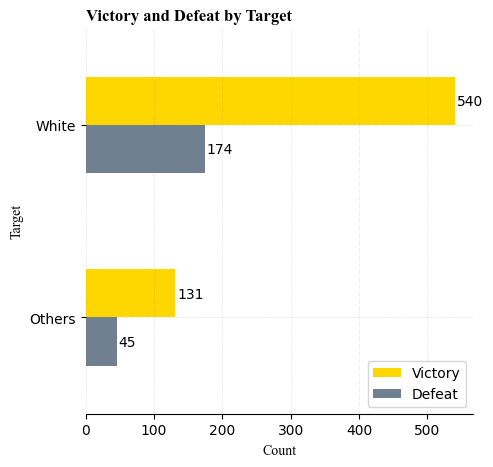

In [22]:
#Vizualise the data
result = pd.DataFrame({
    'Target' : ['White', 'Others'],
    'Victory' : [vic_white, vic_others],
    'Defeat' : [def_white, def_others]
})

fig, ax = plt.subplots(figsize=(5, 5))

# Barres horizontales
result.plot(x='Target', y=['Victory', 'Defeat'], kind="barh", ax=ax, color=['gold', 'slategrey'])

# Personnalisation supplémentaire si nécessaire
ax.set_title('Victory and Defeat by Target',fontname='Times New Roman', fontweight='bold', loc ='left')
ax.set_xlabel('Count',fontname='Times New Roman')
ax.set_ylabel('Target',fontname='Times New Roman')
ax.legend(["Victory", "Defeat"])
ax.invert_yaxis()
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)


# Affichage du graphique
plt.show()


Target white people seems to lead principally victory. The gap between victory and defeat for white people target is way more important than for the other ethnics groups target. Thus, the ethnics groups might influence the finality of the games, with a strong advantages for white people target.
To know if the target person ethnics group has an impact on the result of the game, a statistic test to test the hypothesis. For example, we can do a Chi-2 test with the following null hypothesis : 
- H0 : There is no significant differences in victories dependanding on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 410    | 130   |
| Target Other People   | 131    | 45    |

In [23]:
#chi2 test
contingency_table = [[vic_white, def_white], [vic_others, def_others]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(p_value)

0.8158173437383854


p-value>0.05,  so we can't reject the null hypothesis which says that there is no significant differencies in victories depending on the target people ethnicity. This result is unexpected, as we tought that targetting white people leads more to victory.   

A reason for this unexpected result might be the naïve method used. Indeed, the model is more complex and a lot of factor can influence the victory and the defeat, those factors are called **confounders**.




**b) Analysis considering confounders**

There are some CONFOUNDERS that can affect the finality of the games to victory or defeat : 
- players skills 
- length of the shortest path
- difficulty of the propose games (source to target)

A good way to improve the robustness and the accuracy of our analysis is to fixed those confounders. As confounders can be multiple and with varying degrees of influence, it is better to start by fixing one simple confounders and then increase the contraints. Indeed, starting with a lot of contraints reduce the amount of data signicantly. Analysis with small data amount can be a bad representation of the reality. We have to find a equilibrium between fixing confounders and still having enough of data. We choose to fix the following confounders : 

**1nd possibility** : Compare only the pathways realised from the same source.

**2rd possibility** : Compare only the pathways realised from the same source and with the same shortest path length

**1ND POSSIBILITY :** 

So, we can add the first constraint to sample our data :
- Considering all the path that target a people take paths with the same source.  


To control the confounders, we can match the data by creating pairs of paths. The target articles of the pairs are a white people article and an others ethnics groups article. The matching constraint is starting a path at the same source article for each pairs.


In [24]:
#Create a dataframe with colonne : Start / Target / Target's Ethnicity / Victory or Defeat
defeat = defeat.rename(columns={'target' : 'People'})
defeat = pd.merge(defeat, people_color, on='People')
defeat = defeat.rename(columns= {'People' : 'target', 2 :'Category', })

victory = victory.rename(columns={'target' : 'People'})
victory = pd.merge(victory, people_color, on='People')
victory = victory.rename(columns= {'People' : 'target', 2 :'Category', })

defeat['Result'] = 'defeat'
victory['Result'] = 'victory'
df = pd.concat([defeat, victory], axis = 0)

In [25]:
#Create a function to match the data with the same source
def matching(df):
    white_skin = df[df['Skin Color'] == 'White']
    other_ethnics = df[df['Skin Color'] != 'White']

    matched_pairs = []
    result =[]
    for start in df['start'].unique():
        white_targets = white_skin[white_skin['start'] == start]['target'].tolist()
        non_white_targets = other_ethnics[other_ethnics['start'] == start]['target'].tolist()

        result_white = white_skin[white_skin['start'] == start]['Result'].tolist()
        result_others = other_ethnics[other_ethnics['start'] == start]['Result'].tolist()
        # Créer des paires avec un élément de 'target' avec 'skin color' blanc et un avec un autre 'skin color'
        for w in white_targets:
            for nw in non_white_targets:
                matched_pairs.append((start, w, nw))
        
        for i in result_white : 
            for j in result_others :
                result.append((start, i, j))
    
    # Créer un DataFrame avec les paires créées
    matched= pd.DataFrame(matched_pairs, columns=['start', 'white_skin_target', 'other_ethnics_target'])
    result = pd.DataFrame(result, columns=['start', 'result_white_target', 'result_other_target'])

    matched_df = pd.concat([matched, result], axis=1)
    matched_df = matched_df.loc[:,~matched_df.columns.duplicated()]
    return matched_df

# Utiliser la fonction sur votre DataFrame
# df est votre DataFrame initial avec les colonnes start, target, Skin Color, Category
matched_pairs_df= matching(df)
matched_pairs_df

,start,white_skin_target,other_ethnics_target,result_white_target,result_other_target
0,Reptile,Archimedes,Jesus,defeat,defeat
1,Reptile,Archimedes,Jesus,defeat,victory
2,Reptile,Archimedes,Jesus,defeat,victory
3,Reptile,Archimedes,Jesus,defeat,victory
4,Reptile,Archimedes,Jesus,defeat,victory
...,...,...,...,...,...
570,Golden_Eagle,Euclid,Buddha,victory,victory
571,Radio_telescope,Charlemagne,Buddha,victory,victory
572,Grand_Central_Terminal,Plato,Buddha,victory,victory
573,England,Charlemagne,Muhammad,victory,victory


So after matching the data, it remains 577 paths that correspond to our contraints. We will focus on thos paths to achieve the analysis. The amount of data is sufficient to be representative of our dataset.

In [26]:
#Count the victory and the defeat depending on the target. 
target_white = matched_pairs_df['result_white_target'].value_counts().tolist()
target_others = matched_pairs_df['result_other_target'].value_counts().tolist()

print(target_white)
print(target_others)

[507, 68]
[479, 96]


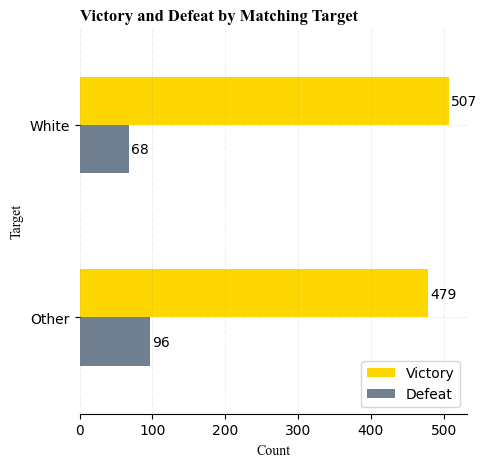

In [27]:
#Vizualise the data
victory_white = target_white[0]
defeat_white = target_white[1]
victory_other = target_others[0]
defeat_other = target_others[1]

result = pd.DataFrame({
    'Target' : ['White', 'Other'],
    'Victory' : [victory_white, victory_other],
    'Defeat' : [defeat_white, defeat_other]
})

fig, ax = plt.subplots(figsize=(5, 5))

# Barres horizontales
result.plot(x='Target', y=['Victory', 'Defeat'], kind="barh", ax=ax, color=['gold', 'slategrey'])

# Personnalisation supplémentaire si nécessaire
ax.set_title('Victory and Defeat by Matching Target',fontname='Times New Roman', fontweight='bold', loc ='left')
ax.set_xlabel('Count',fontname='Times New Roman')
ax.set_ylabel('Target',fontname='Times New Roman')
ax.legend(["Victory", "Defeat"])
ax.invert_yaxis()
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)


# Affichage du graphique
plt.show()

So, with fix confounders the repartition of the victory and the defeat is not the same. Indeed, the gap between victory and defeat is approximately the same for both white people and others ethnic groups. Thus the ethnicity of the people target seems to have no effect on the finality of the game.

As before a chi-2 test can be used to test the hypothesis : 
- H0 : There is no significant differences in victories depending on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

Contingency Matrix :

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 507    | 70    |
| Target Other People   | 480    | 97    |

In [28]:
#chi2 test 

contingency_table = [[victory_white, defeat_white], [victory_other, defeat_other]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(p_value)

0.022789584551987308


The p-value < 0.05, so we reject the null hypothesis in favour of the alternative hypothesis. 
This result is not intuitive when we look at the previous graph. Maybe we can refine our analysis by adding constraint on the confounders such as keeping only the data with the same source and the same shortest path length.

**2ND POSSIBILITY** 

Now we will increase the contrainst of the 1st possibility by adding one. We will keep the data with the same source and with the same shortest path length. So we will match the data as following : 

- Match a source with a white people target and an others ethnics groups target, both path must have the same shortest path length.

In [29]:
#open the data corresponding to the shortest path length
shortest_distance_text = np.loadtxt(dataFolder + "shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)

# The Shortest Distance Matrix is created from the imported data
shortest_distance_matrix = [] 
for row in shortest_distance_text:
    row_formated = [] 
    for c in row:
        if c.isdigit(): 
            row_formated.append(int(c))
        else:
            row_formated.append(-1) ## If there is no path between two articles it's represented with -1
        
    shortest_distance_matrix.append(np.array(row_formated))

shortest_distance_matrix = np.array(shortest_distance_matrix)
print(shortest_distance_matrix)

[[ 0 -1 -1 ...  4  4  2]
 [-1  0 -1 ...  3  3  3]
 [-1 -1  0 ...  3  3  3]
 ...
 [-1 -1 -1 ...  0  3  3]
 [-1 -1 -1 ...  4  0  3]
 [-1 -1 -1 ...  3  3  0]]


In [30]:
shortest_distance_df = pd.concat([articlesSeries, pd.DataFrame(shortest_distance_matrix)], axis = 1)

#Rename columns with target articles
col = articlesSeries.tolist()
col.insert(0, 'start')  
shortest_distance_df.columns = col
shortest_distance_df

,start,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
0,Áedán_mac_Gabráin,0,-1,-1,-1,-1,-1,3,3,3,...,4,3,3,4,4,3,4,4,4,2
1,Åland,-1,0,-1,-1,-1,-1,2,2,2,...,4,2,3,4,4,3,4,3,3,3
2,Édouard_Manet,-1,-1,0,-1,-1,-1,3,3,2,...,4,3,2,3,4,3,4,3,3,3
3,Éire,-1,-1,-1,0,-1,-1,3,3,3,...,4,2,2,3,4,3,4,4,3,3
4,Óengus_I_of_the_Picts,-1,-1,-1,-1,0,-1,2,2,3,...,4,2,3,4,4,3,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,-1,-1,-1,-1,-1,-1,2,2,2,...,3,2,2,3,3,0,3,3,3,2
4600,Zirconium,-1,-1,-1,-1,-1,-1,3,3,3,...,3,3,2,2,3,3,0,3,4,3
4601,Zoroaster,-1,-1,-1,-1,-1,-1,2,2,2,...,3,2,2,3,4,3,3,0,3,3
4602,Zuid-Gelders,-1,-1,-1,-1,-1,-1,3,3,3,...,4,3,3,4,4,3,5,4,0,3


In [31]:
#Use the function melt to have the previous result in rows instead of matrix form
shortest_distance_df = shortest_distance_df.melt(id_vars='start', value_name='Distance')
shortest_distance_df = shortest_distance_df.rename(columns = {'variable' : 'target'})


shortest_distance_df = shortest_distance_df[shortest_distance_df['Distance'] != -1]
shortest_distance_df = shortest_distance_df[shortest_distance_df['Distance'] != 0]
shortest_distance_df

,start,target,Distance
27624,Áedán_mac_Gabráin,10th_century,3
27625,Åland,10th_century,2
27626,Édouard_Manet,10th_century,3
27627,Éire,10th_century,3
27628,Óengus_I_of_the_Picts,10th_century,2
...,...,...,...
21196810,Zion_National_Park,Zulu,3
21196811,Zionism,Zulu,2
21196812,Zirconium,Zulu,3
21196813,Zoroaster,Zulu,3


In [32]:
#Only keep the line which target a people article
shortest_distance_people = shortest_distance_df.merge(df, on=['start', 'target'], how='inner')
shortest_distance_people

,start,target,Distance,Skin Color,Category,Result
0,16th_century,Adolf_Hitler,2,White,Political_People,victory
1,1928_Okeechobee_Hurricane,Adolf_Hitler,2,White,Political_People,victory
2,1980_eruption_of_Mount_St._Helens,Adolf_Hitler,3,White,Political_People,victory
3,4-4-0,Adolf_Hitler,3,White,Political_People,victory
4,AIDS,Adolf_Hitler,2,White,Political_People,victory
...,...,...,...,...,...,...
1600,Brush,Zoroaster,3,Arab-Persian-Bizantin,Religious_figures_and_leaders,victory
1601,Cloud,Zoroaster,3,Arab-Persian-Bizantin,Religious_figures_and_leaders,victory
1602,Philippines,Zoroaster,3,Arab-Persian-Bizantin,Religious_figures_and_leaders,defeat
1603,Warsaw,Zoroaster,3,Arab-Persian-Bizantin,Religious_figures_and_leaders,victory


Now we have a dataset containing all the games possibility (start and target) which target a people, with their shortest path length, the ethnics groups and the result of the game. We will match pairs using this dataframe. First, the matching function need to be modify to take into account the shortest path length and only match games with the same shortest path length.

In [33]:
#Create a function to match the data with the same source and the same lenght
def matching(df):
    white_skin = df[df['Skin Color'] == 'White']
    other_ethnics = df[df['Skin Color'] != 'White']

    matched_pairs = []
    result =[]
    for start in df['start'].unique():
        white_targets = white_skin[white_skin['start'] == start]
        other_targets = other_ethnics[other_ethnics['start'] == start]
        
        dist_to_white = white_targets['Distance'].tolist()
        dist_to_other = other_targets['Distance'].tolist()

        result_white = white_skin[white_skin['start'] == start]['Result'].tolist()
        result_others = other_ethnics[other_ethnics['start'] == start]['Result'].tolist()
        
        white_targets = white_targets['target'].tolist()
        other_targets = other_targets['target'].tolist()

        #put the pairs together depending on the shortest path length
        for w in white_targets:
            for nw in other_targets:
                if dist_to_white == dist_to_other:
                    matched_pairs.append((start, w, nw))
            
                    for i in result_white : 
                        for j in result_others :
                            result.append((start, i, j))
    
    # Create a dataframes of the pairs 
    matched= pd.DataFrame(matched_pairs, columns=['start', 'white_skin_target', 'other_ethnics_target'])
    matched = matched.dropna()
    result = pd.DataFrame(result, columns=['start', 'result_white_target', 'result_other_target'])

    matched_df = pd.merge(matched, result, how='inner')
    matched_df = matched_df.loc[:,~matched_df.columns.duplicated()]
    return matched_df

#
# df est votre DataFrame initial avec les colonnes start, target, Skin Color, Category
matched_pairs_df2= matching(shortest_distance_people)
matched_pairs_df2

,start,white_skin_target,other_ethnics_target,result_white_target,result_other_target
0,1980_eruption_of_Mount_St._Helens,Adolf_Hitler,Buddha,victory,victory
1,Beeching_Axe,Adolf_Hitler,Buddha,victory,victory
2,Google,Adolf_Hitler,Jesus,victory,defeat
3,Grand_Central_Terminal,Plato,Buddha,victory,victory
4,England,Charlemagne,Muhammad,victory,victory
...,...,...,...,...,...
66,Bible,Isaac,Jesus,victory,defeat
67,Bible,Isaac,Jesus,victory,victory
68,Bible,Isaac,Jesus,victory,defeat
69,Bible,Isaac,Jesus,victory,victory


In [34]:
#Count the victory and the defeat depending on the target. 
target_white2 = matched_pairs_df2['result_white_target'].value_counts().tolist()
target_others2 = matched_pairs_df2['result_other_target'].value_counts().tolist()

print(target_white2)
print(target_others2)

[71]
[37, 34]


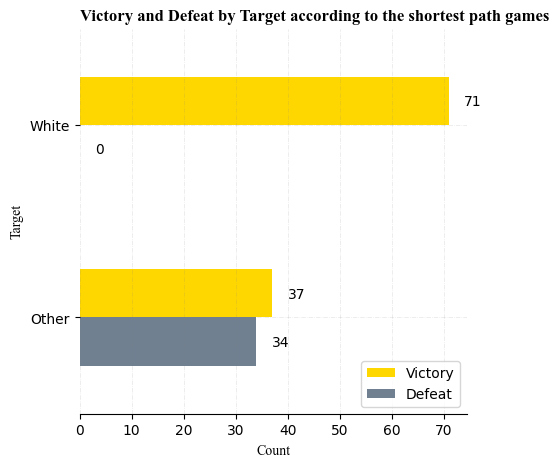

In [35]:
#Vizualise the data
victory_white = target_white2[0]
defeat_white = 0
victory_other = target_others2[0]
defeat_other = target_others2[1]

result = pd.DataFrame({
    'Target' : ['White', 'Other'],
    'Victory' : [victory_white, victory_other],
    'Defeat' : [defeat_white, defeat_other]
})


fig, ax = plt.subplots(figsize=(5, 5))

# Barres horizontales
result.plot(x='Target', y=['Victory', 'Defeat'], kind="barh", ax=ax, color=['gold', 'slategrey'])

# Personnalisation supplémentaire si nécessaire
ax.set_title('Victory and Defeat by Target according to the shortest path games',fontname='Times New Roman', fontweight='bold', loc ='left')
ax.set_xlabel('Count',fontname='Times New Roman')
ax.set_ylabel('Target',fontname='Times New Roman')
ax.legend(["Victory", "Defeat"])
ax.invert_yaxis()
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)


# Affichage du graphique
plt.show()

So according to the previous figure, target a white people lead only to victory for the same source and the same shortest path length whereas target another ethnics groups leads approximately the same to the victory and to the defeat. To make clear conclusion on the influence of the ethnics groups on the result we can do again a statistic test and compare the victory between both groups (white and others). As before, we choose to do a Chi-2 test with the following null hypothesis : 
- H0 : There is no significant differences in victories dependanding on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 71    | 0   |
| Target Other People   | 37   | 34    |

In [36]:
#chi-2 test
contingency_table = [[victory_white, defeat_white], [victory_other, defeat_other]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(p_value)

8.615981625013776e-11


p-value<0.05, so we can reject the null hypthesis which says that there is no significant differences in victories depending the target people ethnics groups. So, target a white person seems to enhance the chance of finished the paths.

It seems to follow our hypothesis of the inequalities between ethnic groups within the Wikispeedia game.

**LINKS ANALYSIS:**

Lets now dive into a link analysis and start by just checking how many links brings you to people belonging to a given ethnic group

In [37]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
people_color_dist=people_color['Skin Color'].value_counts()

In [38]:
# Lets create a dataframe that we will manipulate step by step in order to keep only datas that we want: 
people_links= linksDf

# We remove all accents and spaces within the dataframes 'people_color' (conatining all the people and their ethnic group) 
# and 'people_links' (containing all the wikipedia pages and their links) so that we can compare them easily: 
people_color.People= people_color.People.str.replace(' ', '_')
people_color.People= people_color.People.apply(unidecode)
people_links.Elements= people_links.Elements.apply(unidecode)

# We can now drop all links that don't bring to a person ('links' column of the 'people_links' dataframe)
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['links'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)

In [39]:
# We add the ethnic group of the person on the link in a new column 'l_ethnic': 
l_ethnicity=[]
for i in range (0, len(people_links)):     
    for j in range (0, len(people_color)):
        if people_links['links'][i]== people_color['People'][j]:
            l_ethnicity= l_ethnicity+ [people_color['Skin Color'][j]]
            break 
people_links['l_ethnicity']= l_ethnicity
people_links.head(20)

,Elements,links,l_ethnicity
0,Aedan_mac_Gabrain,Columba,White
1,Edouard_Manet,Claude_Monet,White
2,Edouard_Manet,Edgar_Allan_Poe,White
3,Edouard_Manet,Francisco_Goya,White
4,Edouard_Manet,Raphael,White
5,Eire,George_VI_of_the_United_Kingdom,White
6,EUR2_commemorative_coins,Christopher_Columbus,White
7,EUR2_commemorative_coins,Galileo_Galilei,White
8,EUR2_commemorative_coins,Harold_Macmillan,White
9,EUR2_commemorative_coins,Miguel_de_Cervantes,White


In [40]:
# We can then count the number of links that bring to a person of certain ethnic group: 
links_per_ethnic_groups = people_links.groupby(['l_ethnicity']).size().reset_index(name='nb_links')
links_per_ethnic_groups

,l_ethnicity,nb_links
0,American Indian,3
1,Arab-Persian-Bizantin,295
2,Asian,343
3,Australian Aboriginal,1
4,Black,201
5,Hispanic,43
6,White,8827


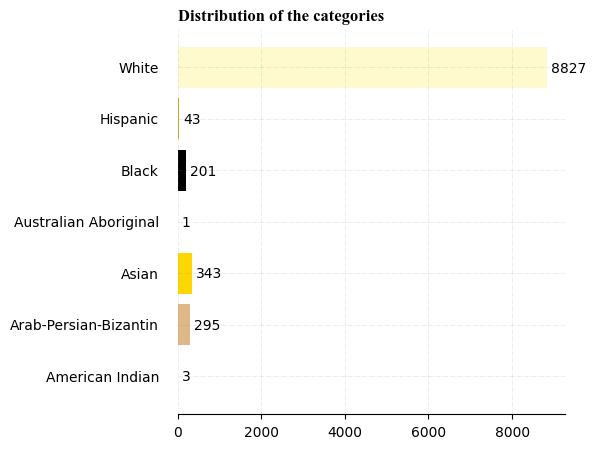

In [41]:
fig,ax =plt.subplots(figsize=(5,5))

couleur= ['chocolate', 'burlywood','gold', 'sienna' ,'black','goldenrod','lemonchiffon' ]

ax.barh(links_per_ethnic_groups['l_ethnicity'],links_per_ethnic_groups['nb_links'], color=couleur)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove y Tick
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)


# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+100, i.get_y()+0.30, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

ax.set_title('Distribution of the categories', loc='left', fontweight= 'bold',fontname='Times New Roman')

plt.show()

Then we can look at the relation between pages of a person of a given ethnic group. To do this we will fisrt keep only pages of 
people that can bring you to other people, after what we will group them by their ethnicity and count the number of links. 

In [42]:
# Now we can drop all wikipedia pages that are not a person ('Elements' column of the 'people_links' dataframe)
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['Elements'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)
people_links


,Elements,links,l_ethnicity
0,Edouard_Manet,Claude_Monet,White
1,Edouard_Manet,Edgar_Allan_Poe,White
2,Edouard_Manet,Francisco_Goya,White
3,Edouard_Manet,Raphael,White
4,Abel_Tasman,James_Cook,White
...,...,...,...
2998,Zoroaster,Friedrich_Nietzsche,White
2999,Zoroaster,Jesus,Arab-Persian-Bizantin
3000,Zoroaster,Muhammad,Arab-Persian-Bizantin
3001,Zoroaster,Plato,White


In [43]:
# We can thus determine the ethnic group of every person on the 'Elements' column and put it in a new column 'E_ethnic':
E_ethnicity = []
for i in range (0, len(people_links)):
    for j in range (0, len(people_color)):
        if people_links['Elements'][i]== people_color['People'][j]:
            E_ethnicity= E_ethnicity + [people_color['Skin Color'][j]]
            break
    
people_links['E_ethnicity']= E_ethnicity
people_links.head(20)

,Elements,links,l_ethnicity,E_ethnicity
0,Edouard_Manet,Claude_Monet,White,White
1,Edouard_Manet,Edgar_Allan_Poe,White,White
2,Edouard_Manet,Francisco_Goya,White,White
3,Edouard_Manet,Raphael,White,White
4,Abel_Tasman,James_Cook,White,White
5,Abraham_Goldfaden,George_Eliot,White,White
6,Abraham_Goldfaden,William_Shakespeare,White,White
7,Abraham_Lincoln,Andrew_Johnson,White,White
8,Abraham_Lincoln,Charles_Darwin,White,White
9,Abraham_Lincoln,Charles_Sumner,White,White


In [44]:
# Now we want to know how many wikipedia pages from people of a certain ethnic group lead to another ethnic group.
ethnic_pair = people_links.groupby(['E_ethnicity', 'l_ethnicity']).size().reset_index(name='nb_links')
ethnic_pair

,E_ethnicity,l_ethnicity,nb_links
0,American Indian,Hispanic,1
1,Arab-Persian-Bizantin,Arab-Persian-Bizantin,15
2,Arab-Persian-Bizantin,Asian,8
3,Arab-Persian-Bizantin,Black,1
4,Arab-Persian-Bizantin,White,41
5,Asian,Arab-Persian-Bizantin,6
6,Asian,Asian,38
7,Asian,Black,5
8,Asian,White,50
9,Australian Aboriginal,White,1


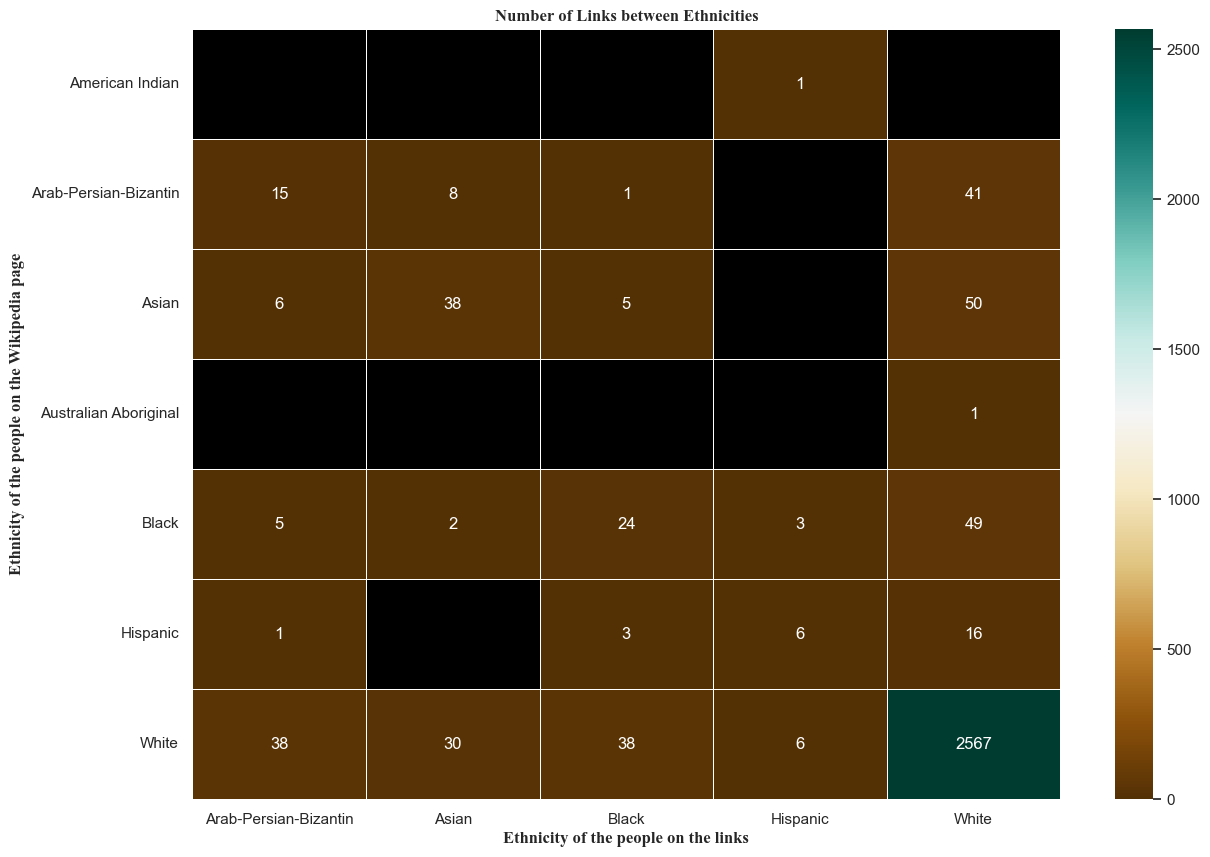

In [45]:
# We want to visualize this data, and a heatmap seems to be the more appropriate method to us: 
heatmap_matrix = ethnic_pair.pivot_table(values='nb_links', index='E_ethnicity', columns='l_ethnicity', fill_value=0)
sns.set(style="whitegrid")

cmap = sns.color_palette("BrBG", as_cmap=True)
cmap.set_bad(color='black')
norm = Normalize(vmin=heatmap_matrix.values.min(), vmax=heatmap_matrix.values.max())

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap=cmap, fmt=".0f", linewidths=.5, mask=(heatmap_matrix == 0),norm=norm)
plt.title('Number of Links between Ethnicities', fontname="Times New Roman", fontweight="bold")
plt.xlabel('Ethnicity of the people on the links',fontname="Times New Roman", fontweight="bold")
plt.ylabel('Ethnicity of the people on the Wikipedia page',fontname="Times New Roman", fontweight="bold")
plt.show()

In [46]:
# To get something less biased, we'll try to find out the proportion of links between each ethnic group. 
# To do this, we divide each pair of links by the total number of links on wikipedia pages belonging to people of a given ethnic group.  
# This gives us:

links_per_ethnicity= ethnic_pair.groupby(['E_ethnicity']).sum().reset_index()
ethnic_pair['nb_links_reajust']= ethnic_pair.nb_links
for i in range (0, len(links_per_ethnicity)):
    for j in range (0, len(ethnic_pair)):
        if ethnic_pair['E_ethnicity'][j]== links_per_ethnicity['E_ethnicity'][i]: 
            ethnic_pair['nb_links_reajust'][j]= ethnic_pair['nb_links'][j]/links_per_ethnicity['nb_links'][i]

ethnic_pair

/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_33483/2834029055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnic_pair['nb_links_reajust'][j]= ethnic_pair['nb_links'][j]/links_per_ethnicity['nb_links'][i]
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_33483/2834029055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnic_pair['nb_links_reajust'][j]= ethnic_pair['nb_links'][j]/links_per_ethnicity['nb_links'][i]
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_33483/2834029055.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a fu

,E_ethnicity,l_ethnicity,nb_links,nb_links_reajust
0,American Indian,Hispanic,1,1.000000
1,Arab-Persian-Bizantin,Arab-Persian-Bizantin,15,0.230769
2,Arab-Persian-Bizantin,Asian,8,0.123077
3,Arab-Persian-Bizantin,Black,1,0.015385
4,Arab-Persian-Bizantin,White,41,0.630769
5,Asian,Arab-Persian-Bizantin,6,0.060606
6,Asian,Asian,38,0.383838
7,Asian,Black,5,0.050505
8,Asian,White,50,0.505051
9,Australian Aboriginal,White,1,1.000000


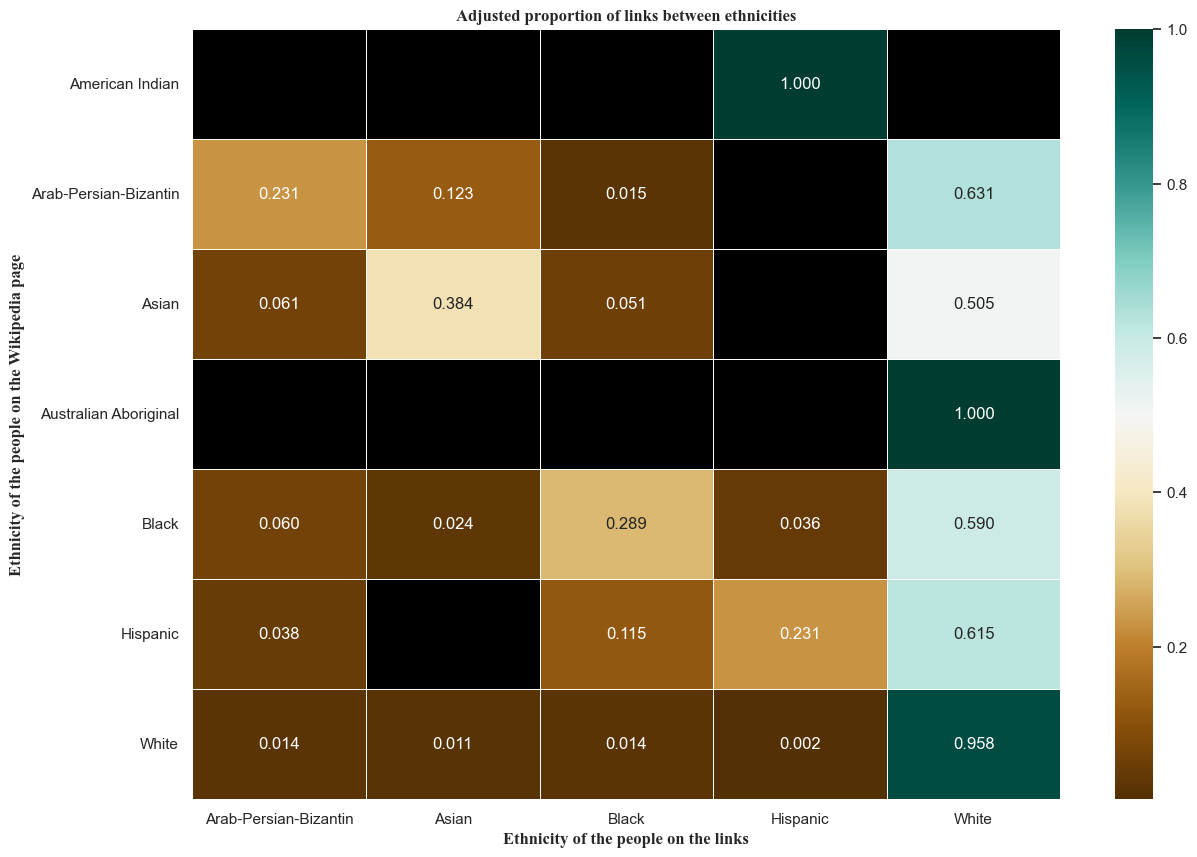

In [47]:
# We want to visualize this data, and again a heatmap seems to be the more appropriate method to us: 
heatmap_matrix = ethnic_pair.pivot_table(values='nb_links_reajust', index='E_ethnicity', columns='l_ethnicity', fill_value=0)
sns.set(style="whitegrid")

cmap = sns.color_palette("BrBG", as_cmap=True)
cmap.set_bad(color='black')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap=cmap, fmt=".3f", linewidths=.5, mask=(heatmap_matrix == 0))
plt.title('Adjusted proportion of links between ethnicities',fontname="Times New Roman", fontweight="bold")
plt.xlabel('Ethnicity of the people on the links',fontname="Times New Roman", fontweight="bold")
plt.ylabel('Ethnicity of the people on the Wikipedia page',fontname="Times New Roman", fontweight="bold")
plt.show()

**Points for improvement:**

- Make deep copies of the Dataframe
- Order the ideas of the notebook
- Take out the extreme values for the analysis


